In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, random_split
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer
from compute_fft import compute_spectrogram, plot_spectrogram, mask
from models.CNN_BiLSTM_Attention import ParallelModel
from BESTRq_classes.models import AttentionLSTM, GRUPredictor, AttentionLSTM_spec
from BESTRq_classes.train import pretrain
from models.PainAttFramework.mainPainatt import PainAttnNet

## Defining classes and training functions

In [2]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [3]:
filepath = 'data/cassette-th-data-all.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
xtrain = xtrain.permute(0, 2, 1)
xvalid = xvalid.permute(0, 2, 1)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(2, torch.Size([175995, 2, 600]))

## First overview on raw signals and spectrograms

### Raw signals

In [4]:
device = th.device('mps')

model = BestRqFramework(input_feature_size= 1200, quantizer_dim= 200, codebook_size=  500, mask_time = 30,
                        random_state= 34, mask_prob= 0.1, num_masks_per_signal= 4, batch_size= 200, device = device,
                        raw_signal = False)


inputs = xtrain[:500, :, :].to(device)
    # `(batch size)` Number of available time steps per batch

input_values = model(inputs.unsqueeze(2), masking = False)

input_values.unique()

tensor([  3,   5,   6,   8,  13,  14,  15,  23,  26,  29,  34,  35,  38,  39,
         40,  41,  46,  48,  53,  59,  60,  61,  62,  64,  66,  67,  70,  71,
         75,  79,  81,  82,  87,  94,  96,  97, 100, 101, 106, 111, 112, 114,
        116, 117, 118, 120, 122, 124, 125, 127, 129, 133, 137, 143, 145, 147,
        148, 150, 152, 153, 155, 169, 171, 176, 182, 183, 184, 186, 187, 196,
        197], device='mps:0')

Text(0.5, 0.98, 'Visualisation du masque')

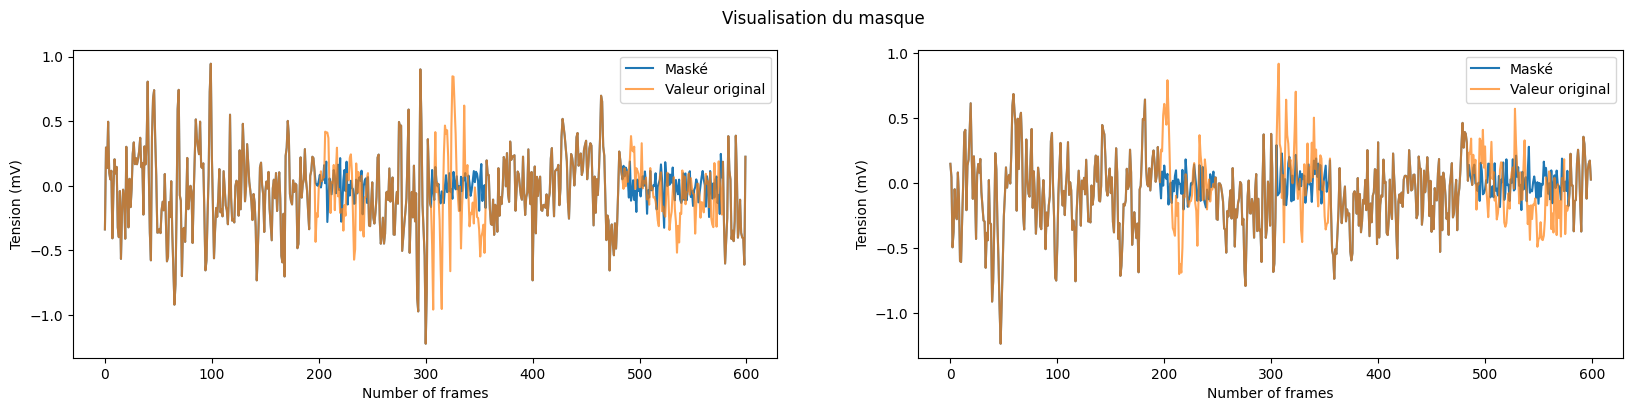

In [14]:
model = BestRqFramework(input_feature_size= 1200, quantizer_dim= 200, codebook_size=  500, mask_time = 30,
                        random_state= 34, mask_prob= 0.1, num_masks_per_signal= 4, batch_size= 200, device = device,
                        raw_signal = False)


inputs = xtrain[:200, : ,:].to(device)


masked_values,_ = mask(inputs, mask_prob = 1, mask_time = 50, number_of_mask = 4, device = device, raw_signal = True)


fig, ax = plt.subplots(1, 2,figsize=(20,4))
for i in range(2):
    ax[i].plot(masked_values[0,i,:].cpu().detach().numpy(), label = 'Maské')
    ax[i].plot(inputs[0, i ,:].cpu().detach().numpy(), label ='Valeur original', alpha = 0.7)
    ax[i].legend()
    ax[i].set_xlabel('Number of frames')
    ax[i].set_ylabel('Tension (mV)')
fig.suptitle('Visualisation du masque')

### Spectrograms

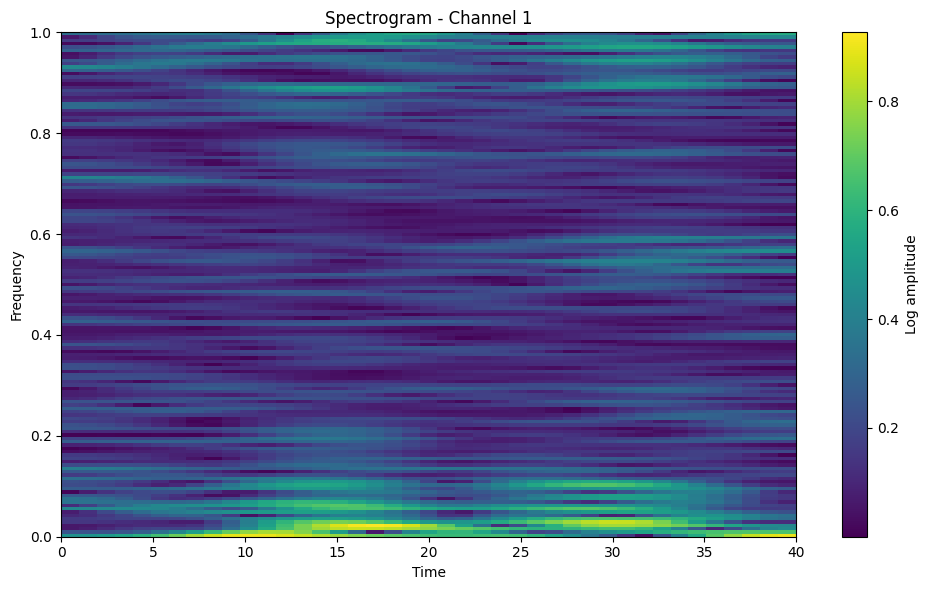

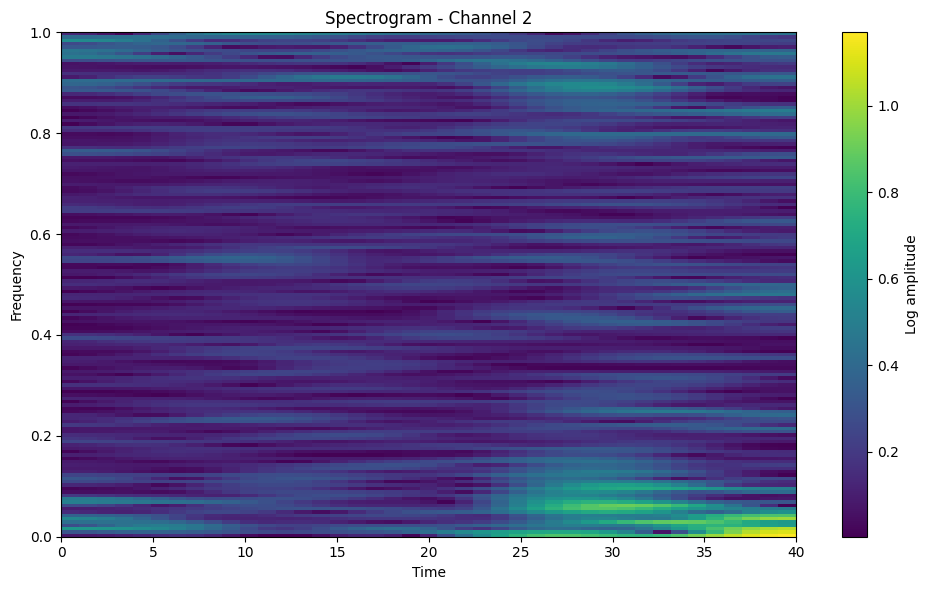

In [18]:
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
inputs = xtrain[:200].to('cpu').view(200, 2, 600)
stft = compute_spectrogram(inputs, n_fft = 300).permute(0,3,1,2)
plot_spectrogram(stft[1, :, :, :])

In [21]:

model = BestRqFramework(input_feature_size= 12382, quantizer_dim= 200, codebook_size=  500, mask_time = 30,
                        random_state= 72829, mask_prob= 0.1, num_masks_per_signal= 4, batch_size= 200, device = device,
                        raw_signal = False)


inputs = stft.to(device) # `(batch size)` Number of available time steps per batch

input_values = model(inputs.unsqueeze(2), masking = False)

input_values.unique()

tensor([  0,   1,   6,  16,  83, 102, 111, 146, 196], device='mps:0')

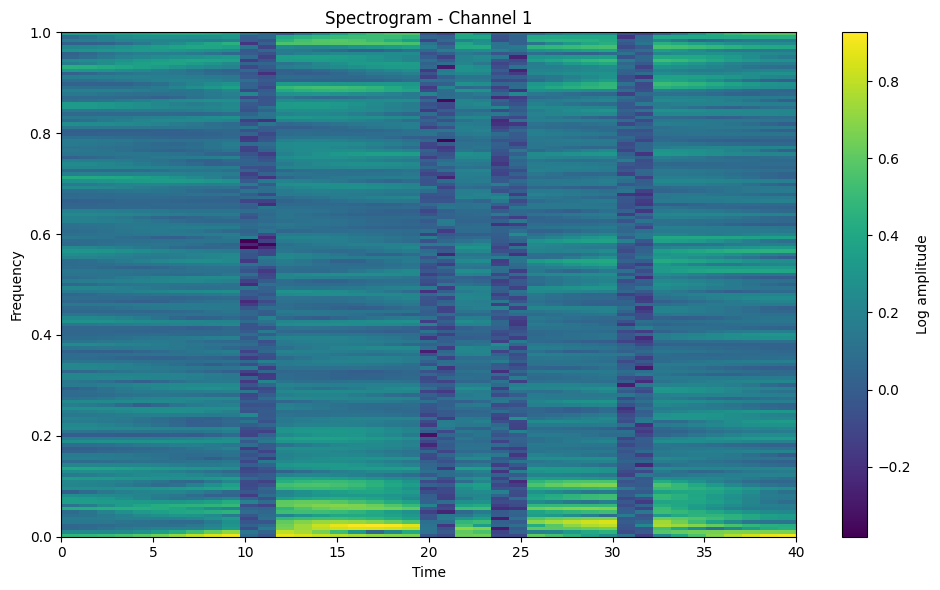

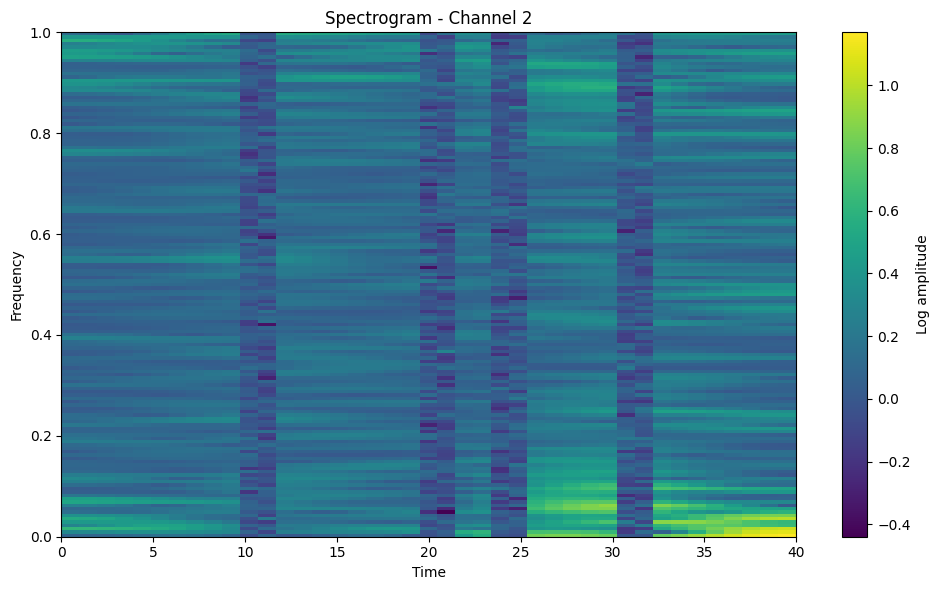

In [26]:
masked_values,_ = mask(stft, mask_prob = 1, mask_time = 2, number_of_mask = 4, device = device, raw_signal = False)
plot_spectrogram(masked_values[1, :, :, :].cpu())

## Training the encoder on raw signals 

In [27]:


xtrain = xtrain.permute(0,2,1)
xvalid = xvalid.permute(0,2,1)

In [3]:
### Try on EOG ####
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain = (xtrain - xtrain.mean(dim = 0))/xtrain.std(dim = 0)
xvalid = (xvalid - xvalid.mean(dim = 0))/xvalid.std(dim = 0)
xtrain = xtrain.unsqueeze(1)
xvalid = xvalid.unsqueeze(1)

device = th.device('mps')
encoder = PainAttnNet().to(device)


BestRq =  BestRqFramework(input_feature_size= 600, quantizer_dim= 200, codebook_size=  200, mask_time = 30,
                        random_state= 34, mask_prob= 0.1, num_masks_per_signal= 4, batch_size= 200, device = device,
                        raw_signal = False)

train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain([xtrain, ytrain], [xvalid, yvalid], encoder , BestRq, ratio_dataset = 3, epochs=10, lr=1e-3, device = device, raw_signal = True, batch_size = 200)

Projection done
Training loader ok
Validation loader ok
Training started


  0%|          | 0/10 [00:00<?, ?it/s]

Validation


 10%|█         | 1/10 [02:24<21:39, 144.38s/it]

Epoch 1/10, Train Loss: 3.0153894716379592, Validation Loss: 2.590765122211341, Training Accuracy: 0.3061621068780363, Validation Accuracy: 0.3845087773329227
Validation


 20%|██        | 2/10 [04:21<17:08, 128.51s/it]

Epoch 2/10, Train Loss: 2.550613378991886, Validation Loss: 2.305541500900731, Training Accuracy: 0.3790505412085571, Validation Accuracy: 0.42824145364952265
Validation


 30%|███       | 3/10 [06:18<14:22, 123.22s/it]

Epoch 3/10, Train Loss: 2.2961058077358065, Validation Loss: 2.1075909426718047, Training Accuracy: 0.4171311684991051, Validation Accuracy: 0.4648906683092085
Validation


 40%|████      | 4/10 [08:17<12:07, 121.28s/it]

Epoch 4/10, Train Loss: 2.114592346204381, Validation Loss: 2.0085044340653853, Training Accuracy: 0.4471661126736555, Validation Accuracy: 0.47566984909146903
Validation


 50%|█████     | 5/10 [10:21<10:11, 122.33s/it]

Epoch 5/10, Train Loss: 1.991383357923858, Validation Loss: 1.9574383894602458, Training Accuracy: 0.4703144975709537, Validation Accuracy: 0.4924545734524176
Validation


 60%|██████    | 6/10 [12:23<08:09, 122.28s/it]

Epoch 6/10, Train Loss: 1.8848987363633656, Validation Loss: 1.9175704753760137, Training Accuracy: 0.4865422313133896, Validation Accuracy: 0.4983061287342162


Text(0.5, 0.98, 'Attention-BiLSTM with codebook_size = 70 and hiden_dim = 50 and less masking')

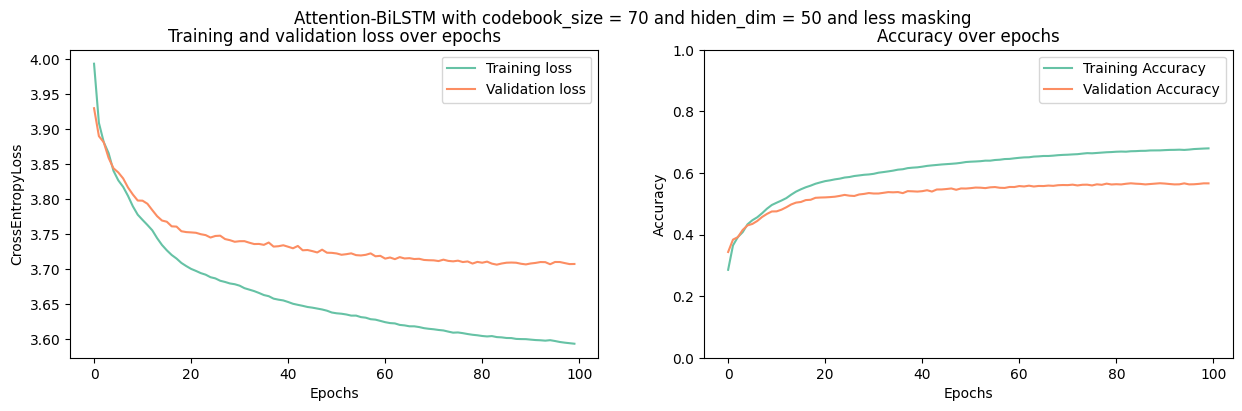

In [ ]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('Attention-BiLSTM with codebook_size = 70 and hiden_dim = 50 and less masking')

In [ ]:
## Saving the model
with open('models/BestRqEncoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

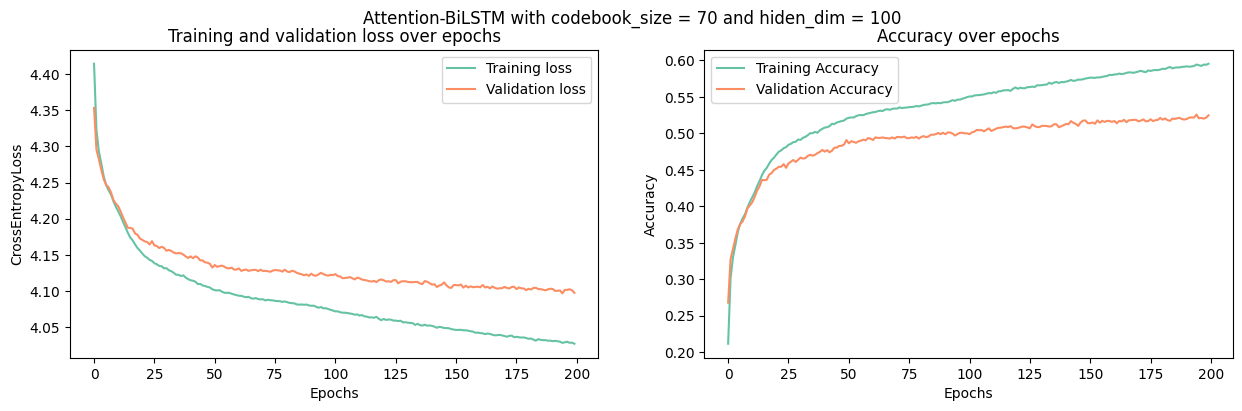

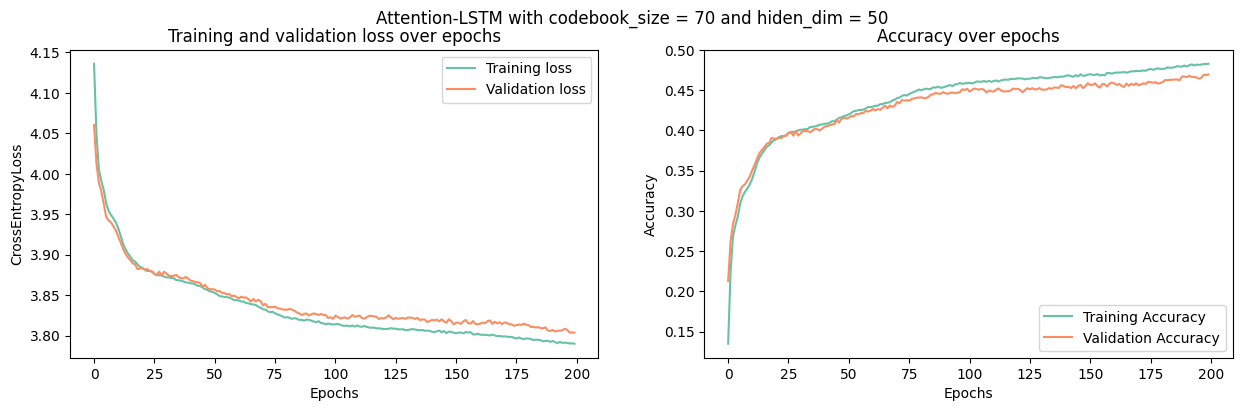

There is some overfitting where the training data is learned in a more efficient way than validation data. (Masking probability here was very high so the LSTM had trouble learning the noise)


### Training the decoder

In [ ]:
decoder = nn.Sequential(nn.Conv2d(70, 32, kernel_size=3, stride=1, padding=1),
nn.Upsample(scale_factor=2, mode="nearest"),
nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
nn.GELU(),
nn.Upsample(scale_factor=2, mode="nearest"),
nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1))

SyntaxError: unmatched ')' (3904580648.py, line 6)

In [ ]:
with open('models/BestRqEncoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [ ]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
dataset_t = TensorDataset(xtrain, ytrain)
dataset_size = len(dataset_t)
half_dataset_size = dataset_size // 2
dataset_t1, dataset_t2 = random_split(dataset_t,  [half_dataset_size, dataset_size - half_dataset_size])
train_loader = DataLoader(dataset_t2, batch_size= 500, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
dataset_size = len(dataset_v)
half_dataset_size = dataset_size // 2
dataset_v1, dataset_v2 = random_split(dataset_v,  [half_dataset_size, dataset_size - half_dataset_size])
valid_loader = DataLoader(dataset_v2, batch_size= 500, shuffle=True)

NameError: name 'np' is not defined

In [ ]:
train_losses, valid_losses, train_accuracies, valid_accuracies = train_decoder(trainloader= valid_loader, validloader= train_loader, encoder= encoder, decoder= decoder, device= device, lr = 1e-5)

 10%|█         | 1/10 [00:03<00:28,  3.16s/it]

Epoch 1/10, Train Loss: 1.793897694484754, Validation Loss: 1.7938536763191224, Training Accuracy: 0.07926316507193346, Validation Accuracy: 0.07688359679737221


 20%|██        | 2/10 [00:05<00:23,  2.93s/it]

Epoch 2/10, Train Loss: 1.793897657231851, Validation Loss: 1.7937907993793487, Training Accuracy: 0.07926316507193346, Validation Accuracy: 0.07688359679737221


 30%|███       | 3/10 [00:08<00:19,  2.74s/it]

Epoch 3/10, Train Loss: 1.7938976971940561, Validation Loss: 1.7938562095165254, Training Accuracy: 0.07926316507193346, Validation Accuracy: 0.07688359679737221


 30%|███       | 3/10 [00:09<00:22,  3.17s/it]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('CrossEntropyLoss')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)
fig.suptitle('Encoder + Decoder')

## Trying with spectrogram

In [ ]:
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
xtrain, xvalid = compute_spectrogram(xtrain, n_fft = 400, window=th.hann_window(400)),compute_spectrogram(xvalid,  n_fft = 400, window=th.hann_window(400))

In [ ]:
stft_train, stft_valid   = [], []
for i in range(xtrain.shape[2]):
    feature_train, feature_valid = xtrain[:, :, i], xvalid[:, :, i]
    feature_train, feature_valid = compute_spectrogram(feature_train, n_fft= 300, window=th.hann_window(300)), compute_spectrogram(feature_valid, n_fft= 300, window=th.hann_window(300))
    stft_train.append(feature_train)
    stft_valid.append(feature_valid)
stft_train= th.stack(stft_train, dim=-1)
stft_valid = th.stack(stft_valid, dim = -1)

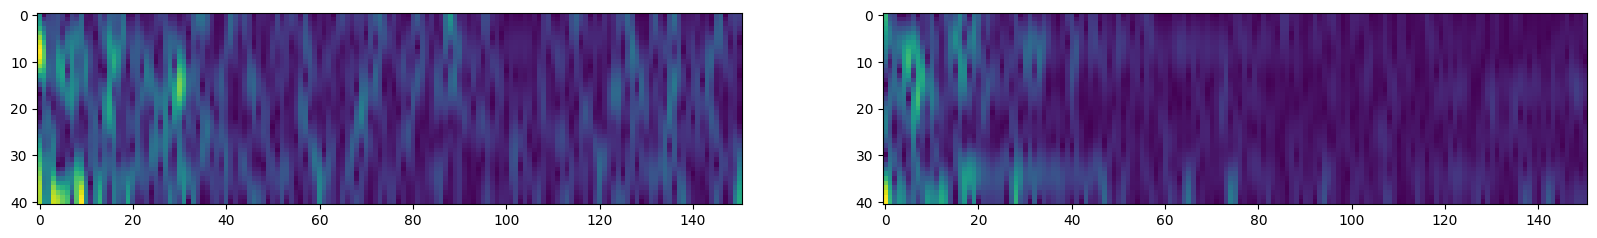

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,15))
ax[0].imshow(stft_train[1, :, :, 1].permute(1,0))
ax[1].imshow(stft_train[1, :, :, 0].permute(1,0))

In [ ]:

mean = stft_train.mean(dim=(0, 2), keepdim=True)
std = stft_train.std(dim=(0, 2), keepdim=True)
# Normalize the tensor
stft_train = (stft_train - mean) / std
mean = stft_valid.mean(dim=(0, 2), keepdim=True)
std = stft_valid.std(dim=(0, 2), keepdim=True)
# Normalize the tensor
stft_valid = (stft_valid - mean) / std
dataset_t = TensorDataset(stft_train, ytrain)
dataset_size = len(dataset_t)
half_dataset_size = dataset_size // 2
dataset_t1, dataset_t2 = random_split(dataset_t,  [half_dataset_size, dataset_size - half_dataset_size])
train_loader = DataLoader(dataset_t1, batch_size= 500, shuffle=True)
dataset_v = TensorDataset(stft_valid, yvalid)
dataset_size = len(dataset_v)
half_dataset_size = dataset_size // 2
dataset_v1, dataset_v2 = random_split(dataset_v,  [half_dataset_size, dataset_size - half_dataset_size])
valid_loader = DataLoader(dataset_v1, batch_size= 500, shuffle=True)

In [ ]:
encoder_spec = ParallelModel(num_codebooks=70)
def train(trainloader, validloader, model, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs, labels  = inputs.to(device), labels.to(device)
            encoder_outs = model(inputs)
            loss = loss_function(encoder_outs, labels.view(-1).long())
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.argmax(encoder_outs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs, labels  = inputs.to(device), labels.to(device)
                encoder_outs = model(inputs)
                loss = loss_function(encoder_outs, labels.view(-1).long())
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.argmax(encoder_outs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [ ]:
model = BestRqFramework(encoder= encoder_spec,
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=201,
                        encoder_hidden_size=150,
                        num_code_books= 20,
                        mask_time= 3,
                        stride_time=1,
                        random_state=6618181,
                        mask_prob=0.1,
                        batch_size=400,
                        raw_signal= False,
                        device = device,
                        input_quantizer_dim = 201*31)

In [ ]:
train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain(trainloader = train_loader, validloader = valid_loader, model = model, device = device, lr = 1e-1, epochs = 200)

  0%|          | 0/200 [10:29<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for inputs, labels in train_loader:
    mean = inputs.mean(dim=(0, 2), keepdim=True)
    std = inputs.std(dim=(0, 2), keepdim=True)

    # Normalize the tensor
    normalized_tensor = (inputs - mean) / std

KeyboardInterrupt: 

In [ ]:
normalized_tensor.mean(dim)

tensor(-1.7659e-08)

In [ ]:
for inputs, labels in train_loader:
    mask, a = mask_and_replace(inputs.unsqueeze(1), mask_prob = 1, mask_time = 6, number_of_mask=4, device = device)

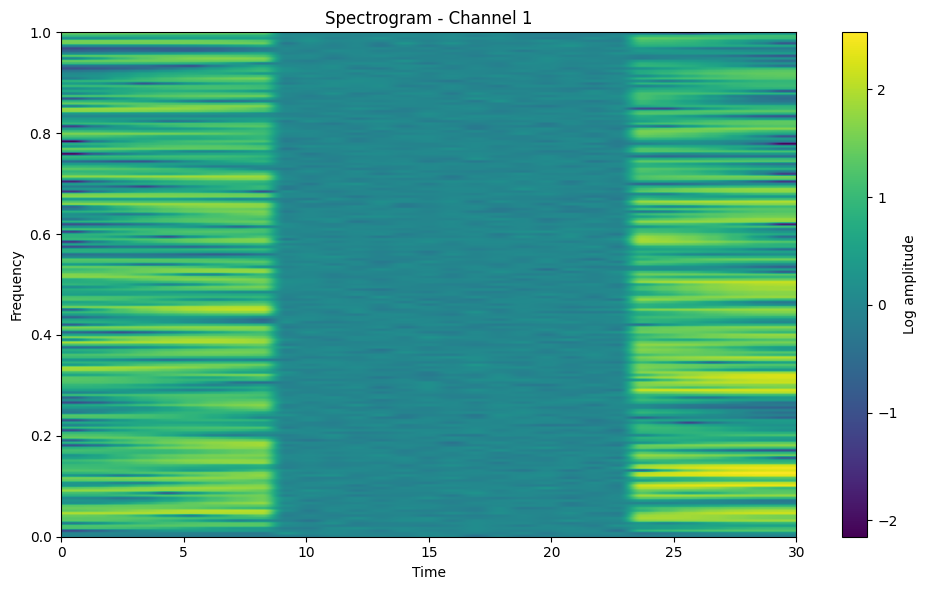

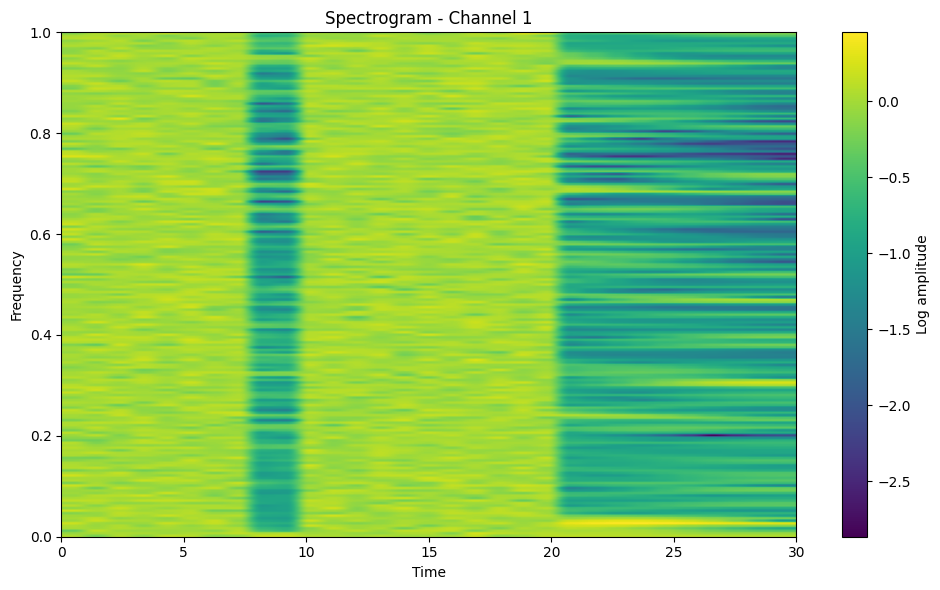

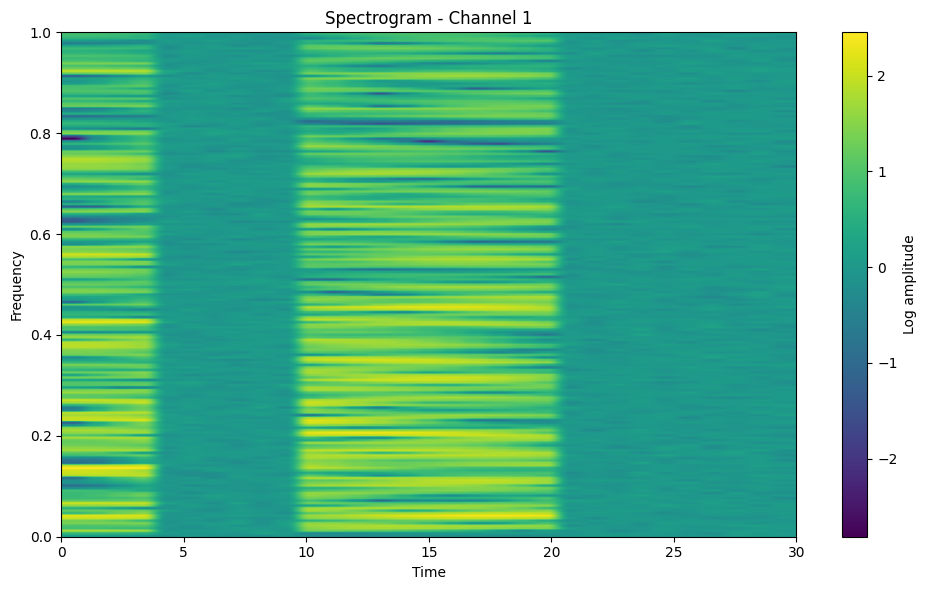

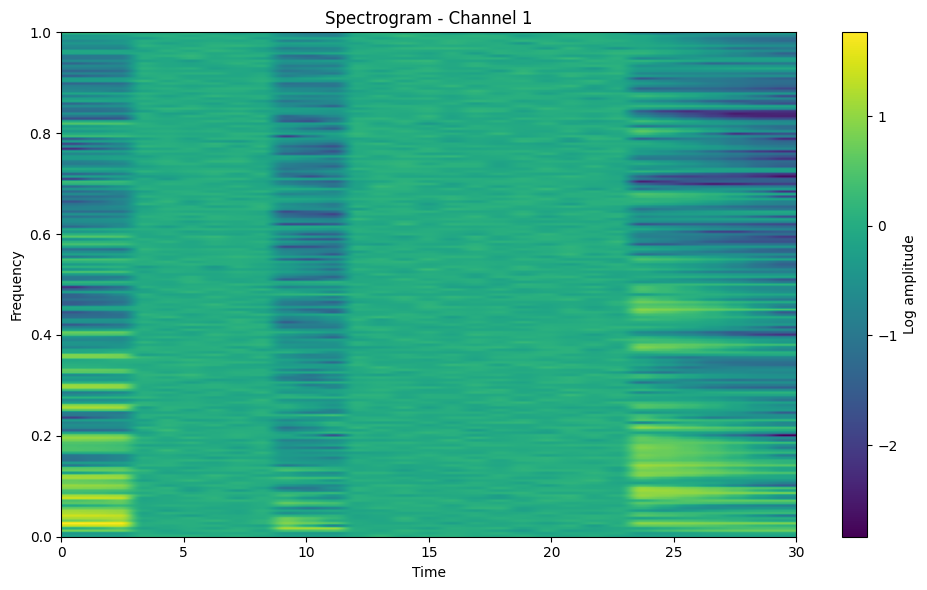

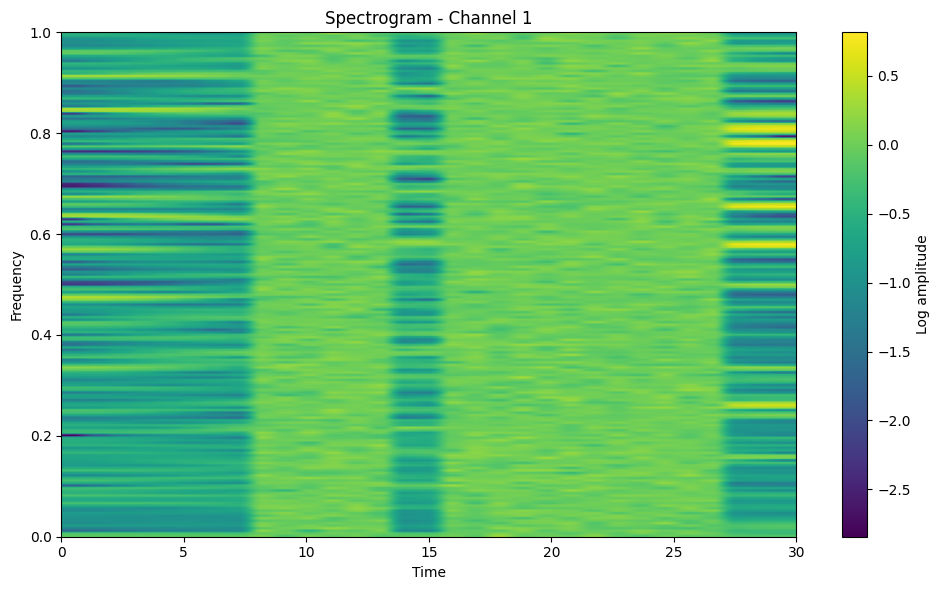

In [ ]:
for i in range(5):
    plot_spectrogram(mask[i, :, :].to('cpu'))

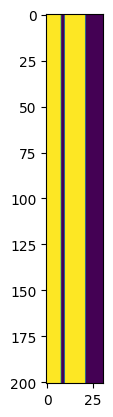

In [ ]:
plt.imshow(a[1, 0 , :, :].cpu())